In [ ]:
from collections import Counter, defaultdict
from gensim.models import Word2Vec
from IPython import display
from nltk import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
from PIL import Image
from torch import nn
from torch.autograd import Variable
from torchvision import models, transforms

import json
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn.functional as F

# Data Acquisition

For this assignment, you will reuse the dataset you downloaded in Assignment 2. You must download the data and extract it into `data/`. We should have 20,000 images ad sentences (one sentence per image in Assignment 2) for training and 100 images with 500 sentences in the validation set (five sentences per image in Assignment 2).

The data file should be the same as from the previous assignment.

In [ ]:
# Define a global transformer to appropriately scale images and subsequently convert them to a Tensor.
img_size = 224
loader = transforms.Compose([
  transforms.Resize(img_size),
  transforms.CenterCrop(img_size),
  transforms.ToTensor(),
]) 
def load_image(filename, volatile=False):
    """
    Simple function to load and preprocess the image.

    1. Open the image.
    2. Scale/crop it and convert it to a float tensor.
    3. Convert it to a variable (all inputs to PyTorch models must be variables).
    4. Add another dimension to the start of the Tensor (b/c VGG expects a batch).
    5. Move the variable onto the GPU.
    """
    image = Image.open(filename).convert('RGB')
    image_tensor = loader(image).float()
    image_var = Variable(image_tensor, volatile=volatile).unsqueeze(0)
    return image_var.cuda()

load_image('data/train2014/COCO_train2014_000000000009.jpg')

tensor([[[[0.0039, 0.0078, 0.0039,  ..., 0.0471, 0.0471, 0.0314],
          [0.0039, 0.0039, 0.0039,  ..., 0.0353, 0.0353, 0.0392],
          [0.0039, 0.0039, 0.0039,  ..., 0.0392, 0.0392, 0.0510],
          ...,
          [0.7137, 0.7294, 0.7137,  ..., 0.1686, 0.1843, 0.1686],
          [0.7059, 0.6902, 0.6863,  ..., 0.1765, 0.1804, 0.2039],
          [0.6784, 0.6667, 0.6706,  ..., 0.1922, 0.2157, 0.2275]],

         [[0.1490, 0.1490, 0.1412,  ..., 0.0039, 0.0039, 0.0039],
          [0.1451, 0.1412, 0.1373,  ..., 0.0039, 0.0039, 0.0039],
          [0.1412, 0.1373, 0.1373,  ..., 0.0039, 0.0039, 0.0039],
          ...,
          [0.4392, 0.4667, 0.4549,  ..., 0.2588, 0.2745, 0.2863],
          [0.4353, 0.4235, 0.4196,  ..., 0.2745, 0.2980, 0.3137],
          [0.4118, 0.4000, 0.4000,  ..., 0.3020, 0.3176, 0.3020]],

         [[0.5294, 0.5294, 0.5294,  ..., 0.1451, 0.1412, 0.1333],
          [0.5255, 0.5333, 0.5373,  ..., 0.1725, 0.1451, 0.1412],
          [0.5373, 0.5490, 0.5451,  ..., 0

In [ ]:
# Load annotations file for the training images.
mscoco_train = json.load(open('data/annotations/train_captions.json'))
train_ids = [entry['id'] for entry in mscoco_train['images']]
train_id_to_file = {entry['id']: 'data/train2014/' + entry['file_name'] for entry in mscoco_train['images']}

# Extract out the captions for the training images
train_id_set = set(train_ids)
train_id_to_captions = defaultdict(list)
for entry in mscoco_train['annotations']:
    if entry['image_id'] in train_id_set:
        train_id_to_captions[entry['image_id']].append(entry['caption'])

# Load annotations file for the validation images.
mscoco_val = json.load(open('data/annotations/val_captions.json'))
val_ids = [entry['id'] for entry in mscoco_val['images']]
val_id_to_file = {entry['id']: 'data/val2014/' + entry['file_name'] for entry in mscoco_val['images']}

# Extract out the captions for the validation images
val_id_set = set(val_ids)
val_id_to_captions = defaultdict(list)
for entry in mscoco_val['annotations']:
    if entry['image_id'] in val_id_set:
        val_id_to_captions[entry['image_id']].append(entry['caption'])

# Load annotations file for the testing images
mscoco_test = json.load(open('data/annotations/test_captions.json'))
test_ids = [entry['id'] for entry in mscoco_test['images']]
test_id_to_file = {entry['id']: 'data/val2014/' + entry['file_name'] for entry in mscoco_test['images']}

# Preprocessing

We do the same preprocessing done in Assignment 3. 

In [ ]:
sentences = [sentence for caption_set in train_id_to_captions.values() for sentence in caption_set]

# Lower-case the sentence, tokenize them and add <SOS> and <EOS> tokens
sentences = [["<SOS>"] + word_tokenize(sentence.lower()) + ["<EOS>"] for sentence in sentences]

# Create the vocabulary. Note that we add an <UNK> token to represent words not in our vocabulary.
vocabularySize = 1000
word_counts = Counter([word for sentence in sentences for word in sentence])
vocabulary = ["<UNK>"] + [e[0] for e in word_counts.most_common(vocabularySize-1)]
word2index = {word:index for index,word in enumerate(vocabulary)}
one_hot_embeddings = np.eye(vocabularySize)

# Build the word2vec embeddings
wordEncodingSize = 300
filtered_sentences = [[word for word in sentence if word in word2index] for sentence in sentences]
w2v = Word2Vec(filtered_sentences, min_count=0, size=wordEncodingSize)
w2v_embeddings = np.concatenate((np.zeros((1, wordEncodingSize)), w2v.wv.syn0))

# Define the max sequence length to be the longest sentence in the training data. 
maxSequenceLength = max([len(sentence) for sentence in sentences])

def preprocess_numberize(sentence):
    """
    Given a sentence, in the form of a string, this function will preprocess it
    into list of numbers (denoting the index into the vocabulary).
    """
    tokenized = word_tokenize(sentence.lower())
        
    # Add the <SOS>/<EOS> tokens and numberize (all unknown words are represented as <UNK>).
    tokenized = ["<SOS>"] + tokenized + ["<EOS>"]
    numberized = [word2index.get(word, 0) for word in tokenized]
    
    return numberized

def preprocess_one_hot(sentence):
    """
    Given a sentence, in the form of a string, this function will preprocess it
    into a numpy array of one-hot vectors.
    """
    numberized = preprocess_numberize(sentence)
    
    # Represent each word as it's one-hot embedding
    one_hot_embedded = one_hot_embeddings[numberized]
    
    return one_hot_embedded

def preprocess_word2vec(sentence):
    """
    Given a sentence, in the form of a string, this function will preprocess it
    into a numpy array of word2vec embeddings.
    """
    numberized = preprocess_numberize(sentence)
    
    # Represent each word as it's one-hot embedding
    w2v_embedded = w2v_embeddings[numberized]
    
    return w2v_embedded

def compute_bleu(reference_sentences, predicted_sentence):
    """
    Given a list of reference sentences, and a predicted sentence, compute the BLEU similary between them.
    """
    reference_tokenized = [word_tokenize(ref_sent.lower()) for ref_sent in reference_sentences]
    predicted_tokenized = word_tokenize(predicted_sentence.lower())
    return sentence_bleu(reference_tokenized, predicted_tokenized)

# 1. Setup Image Encoder

We load in the pre-trained VGG-16 model, and remove the final layer, as done in assignment 2.

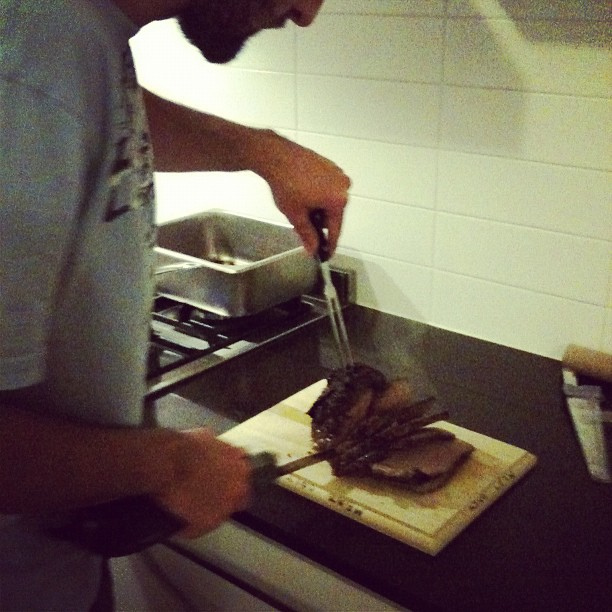

['A person is cutting a roast with a fork and knife.']


In [ ]:
# Your code goes here

# Sample display of paired data
display.display(display.Image(train_id_to_file[train_ids[1]]))
print(train_id_to_captions[train_ids[1]])


# 2. Setup a Language Decoder

We're going to reuse our decoder from Assignment 3.

In [ ]:
# Your code goes here

# 3. Train encoder-decoder



In [ ]:
# Your code goes here

# 4. MAP and Sampling Inference


In [ ]:
# Your code goes here

# 5. Evaluate performance

For validation images compute the average BLEU score.

In [ ]:
# Your code goes here

# 6. Attetion model

Now build a self-attention mechanism.

In [ ]:
# Your code goes here

# 5. Evaluate performance 

For validation images compute the average BLEU score.

In [ ]:
# Your code goes here